In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import math
import psycopg2 as psql
from psycopg2.extras import RealDictCursor
import seaborn as sns
sns.set(color_codes=True)

import sys
sys.path.append("..")
from tools.flight_projection import *

import warnings
warnings.filterwarnings('ignore')

/home/victor/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [23]:
try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

cur_read = conn.cursor(cursor_factory=RealDictCursor)
# cur_read.execute("SELECT * FROM public.ddr2_flights LIMIT 500;")

<h2>Visualization of DDR2 and ADS-B data sets</h2>
The following code will plot the parsed DDR2 and ADS-B flights which have already been merged based on callsign and timestamp. Within the DDR2 flights there are both m1 and m3 files for respectively the planned and actual route. The ADS-B data is more granular. Interesting to see is that there are differences as well between DDR2-m3 and ADS-B

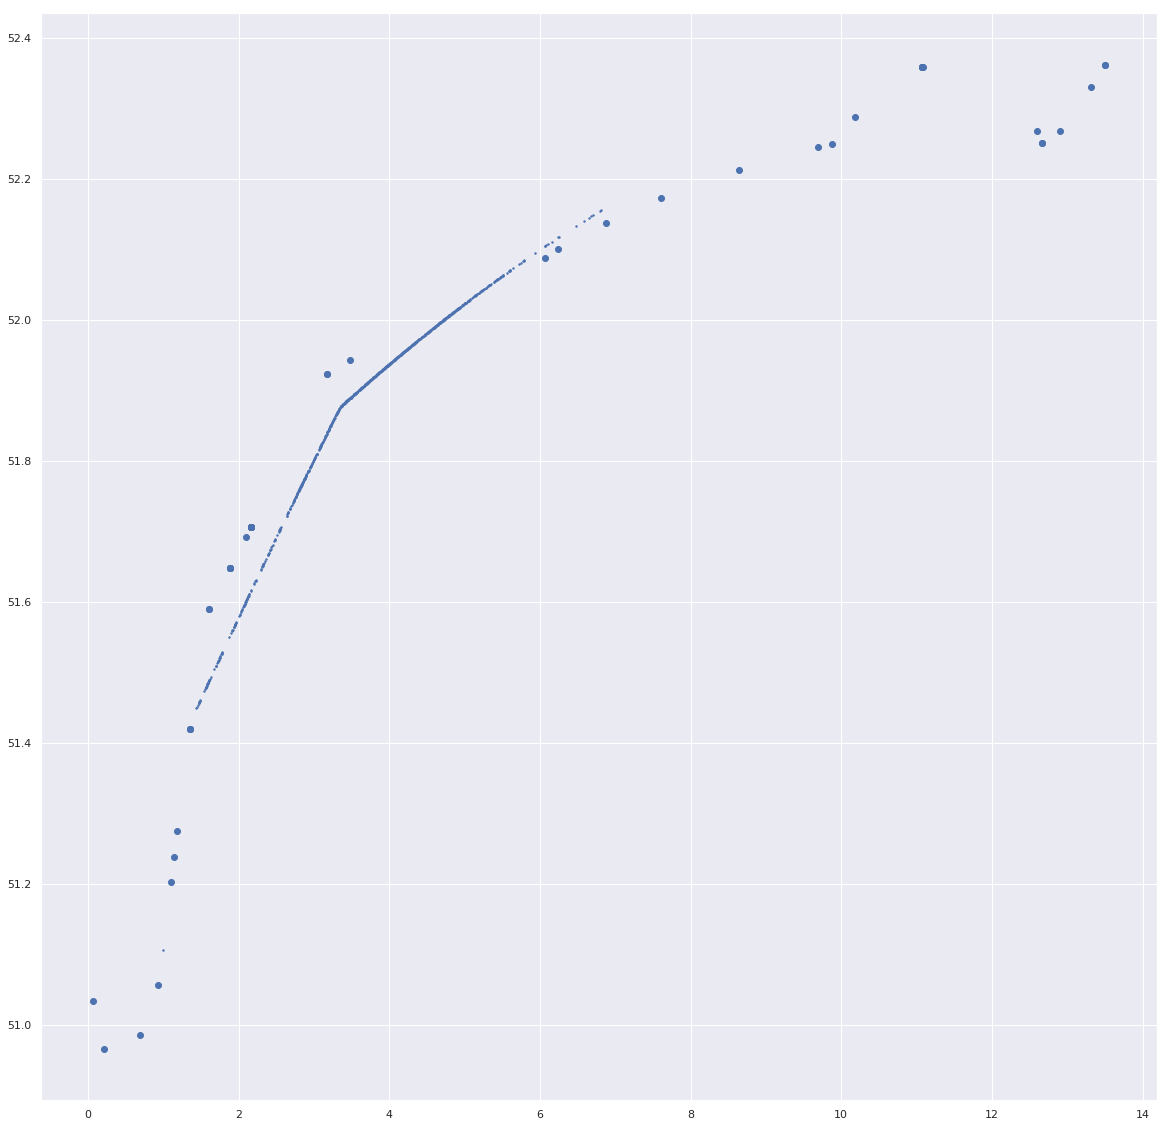

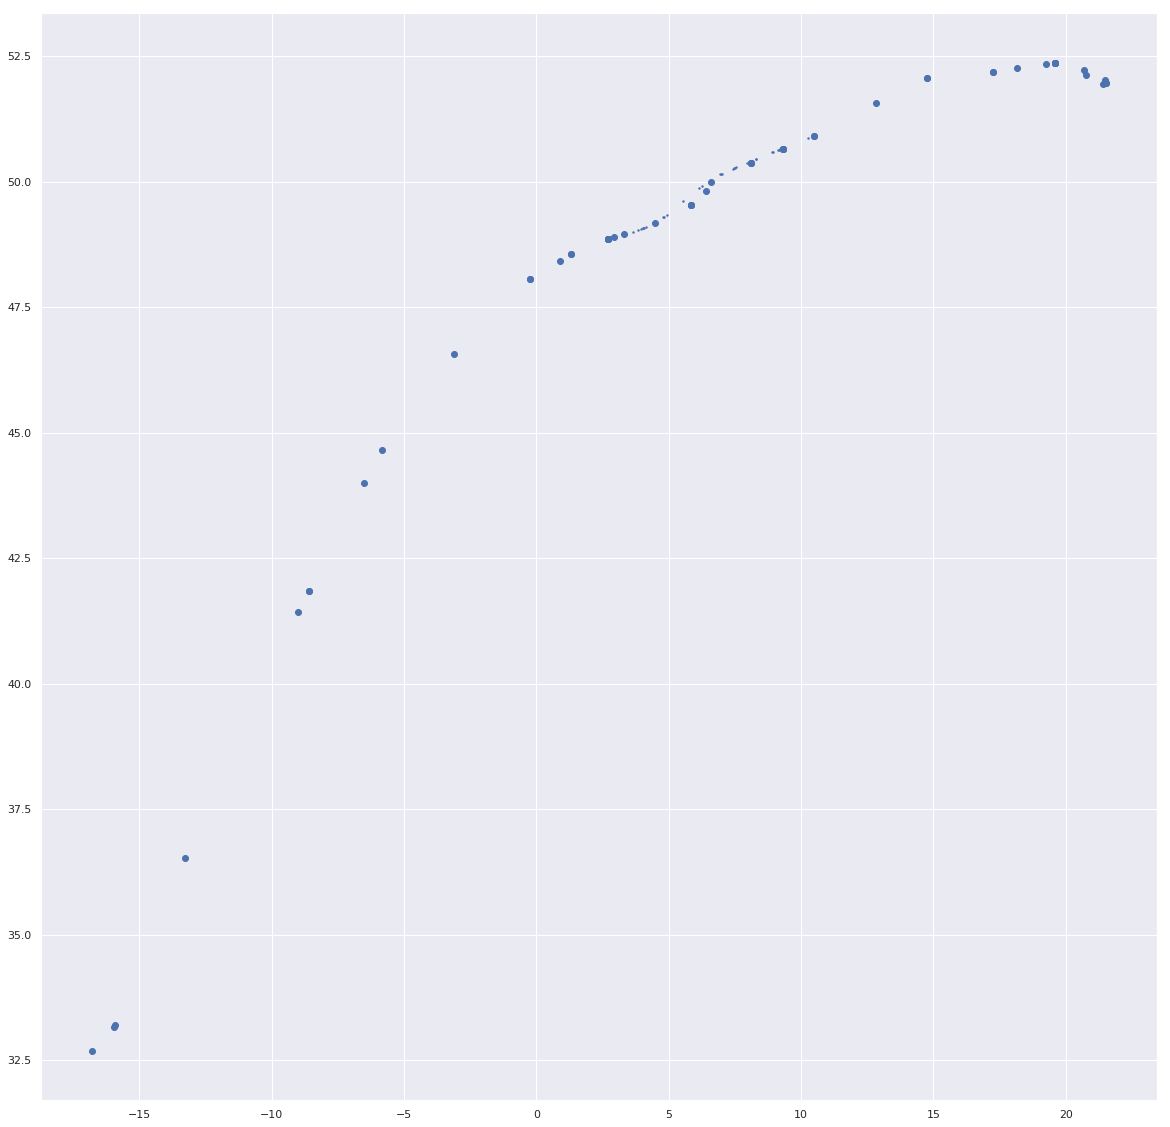

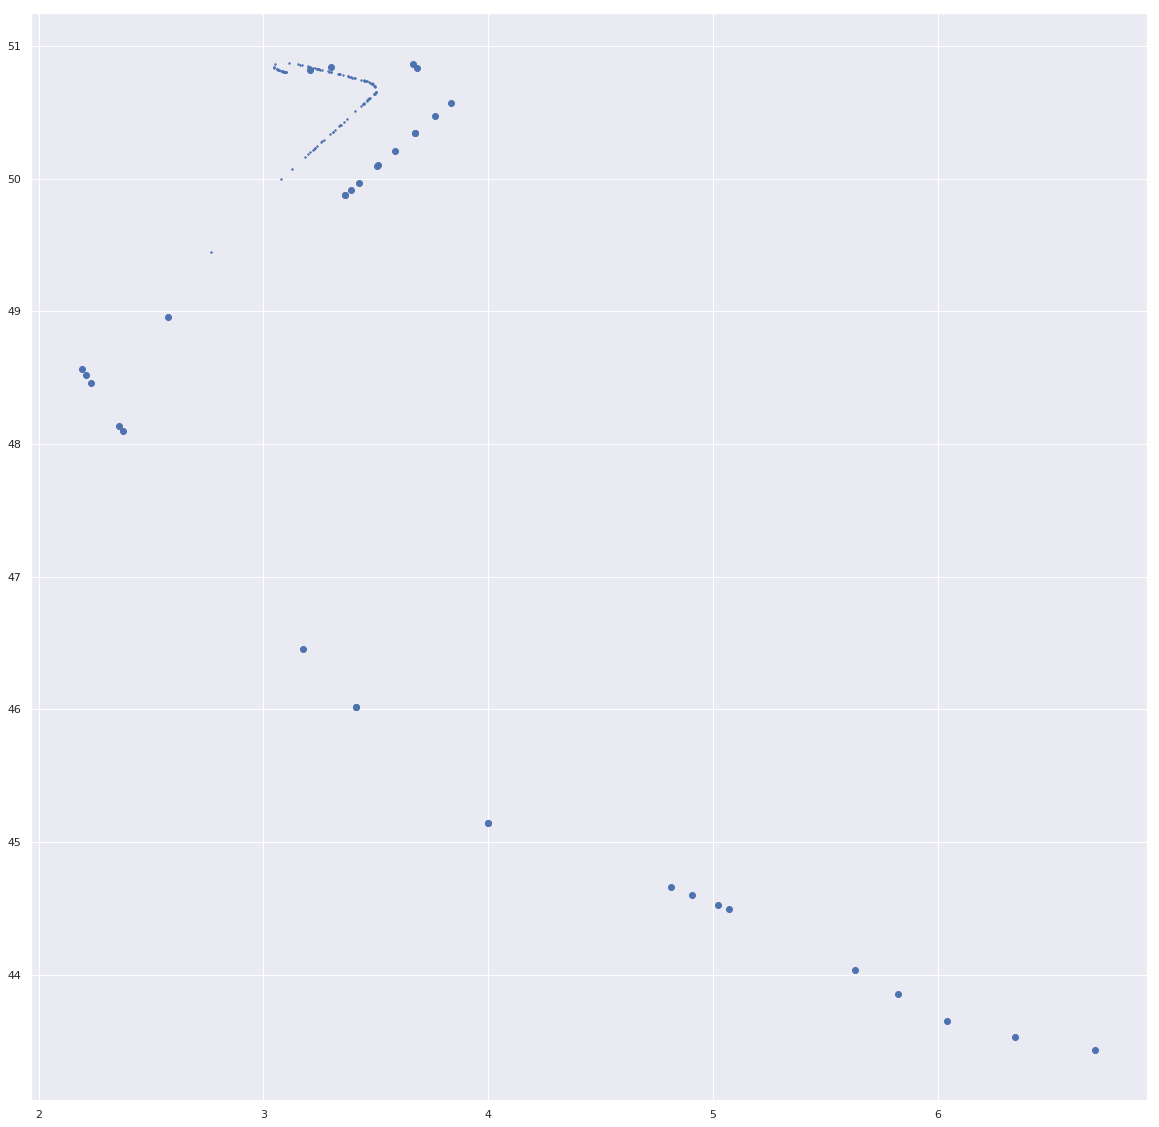

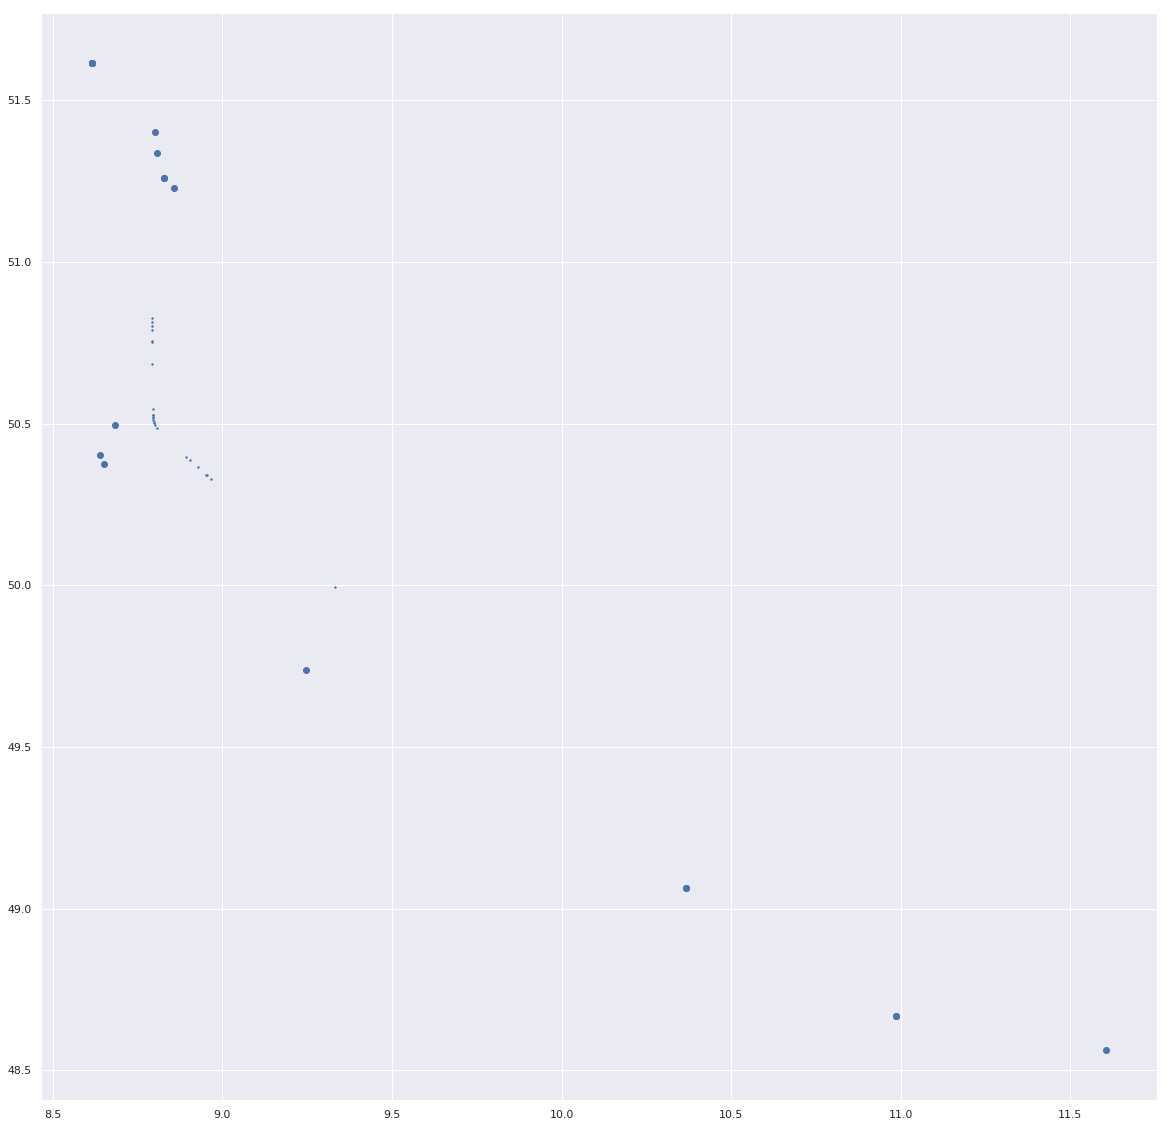

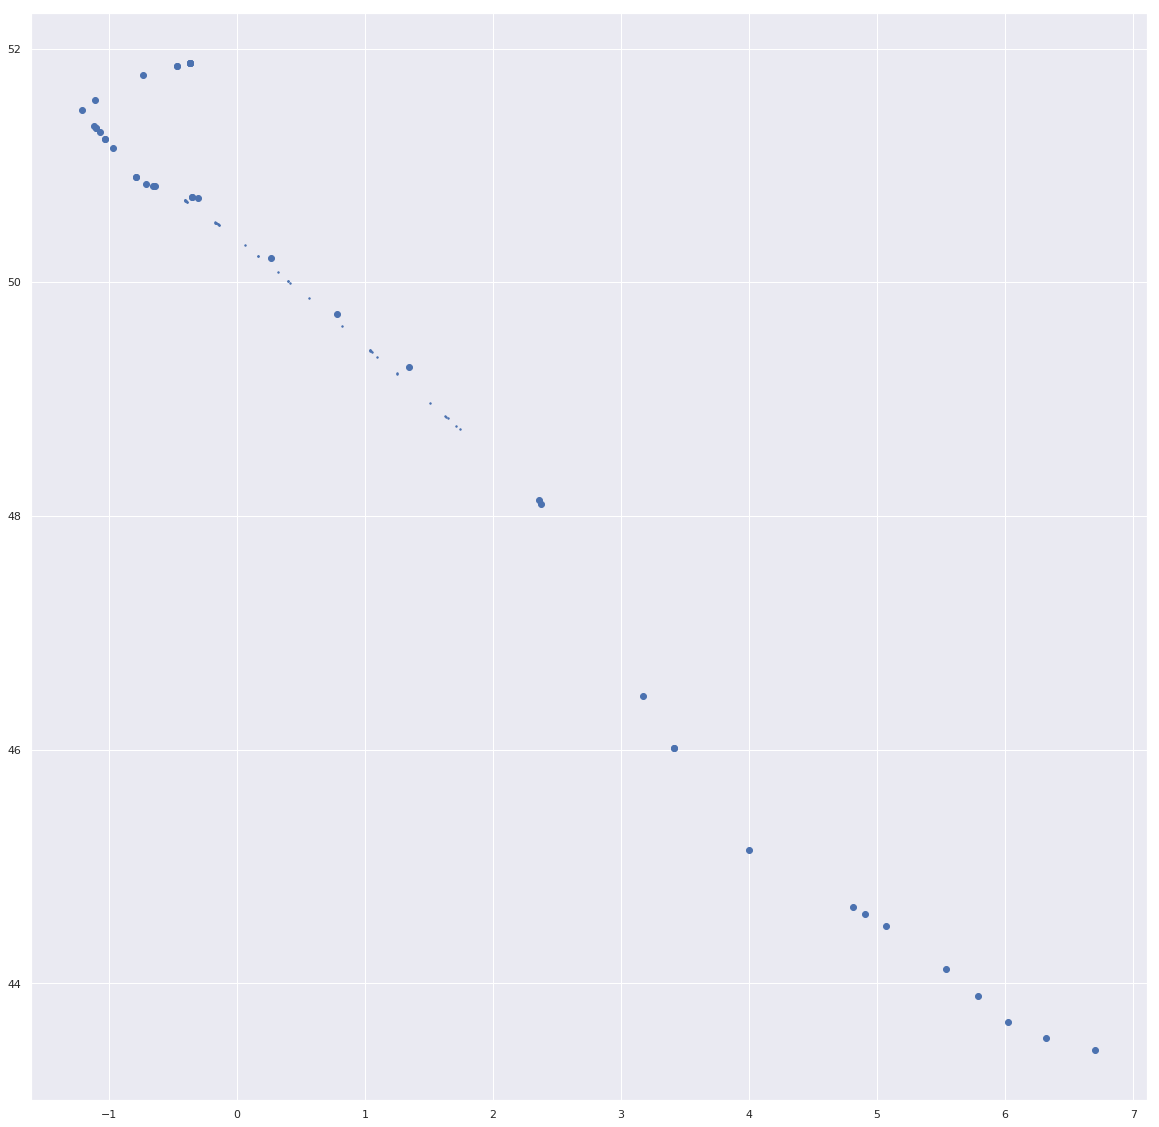

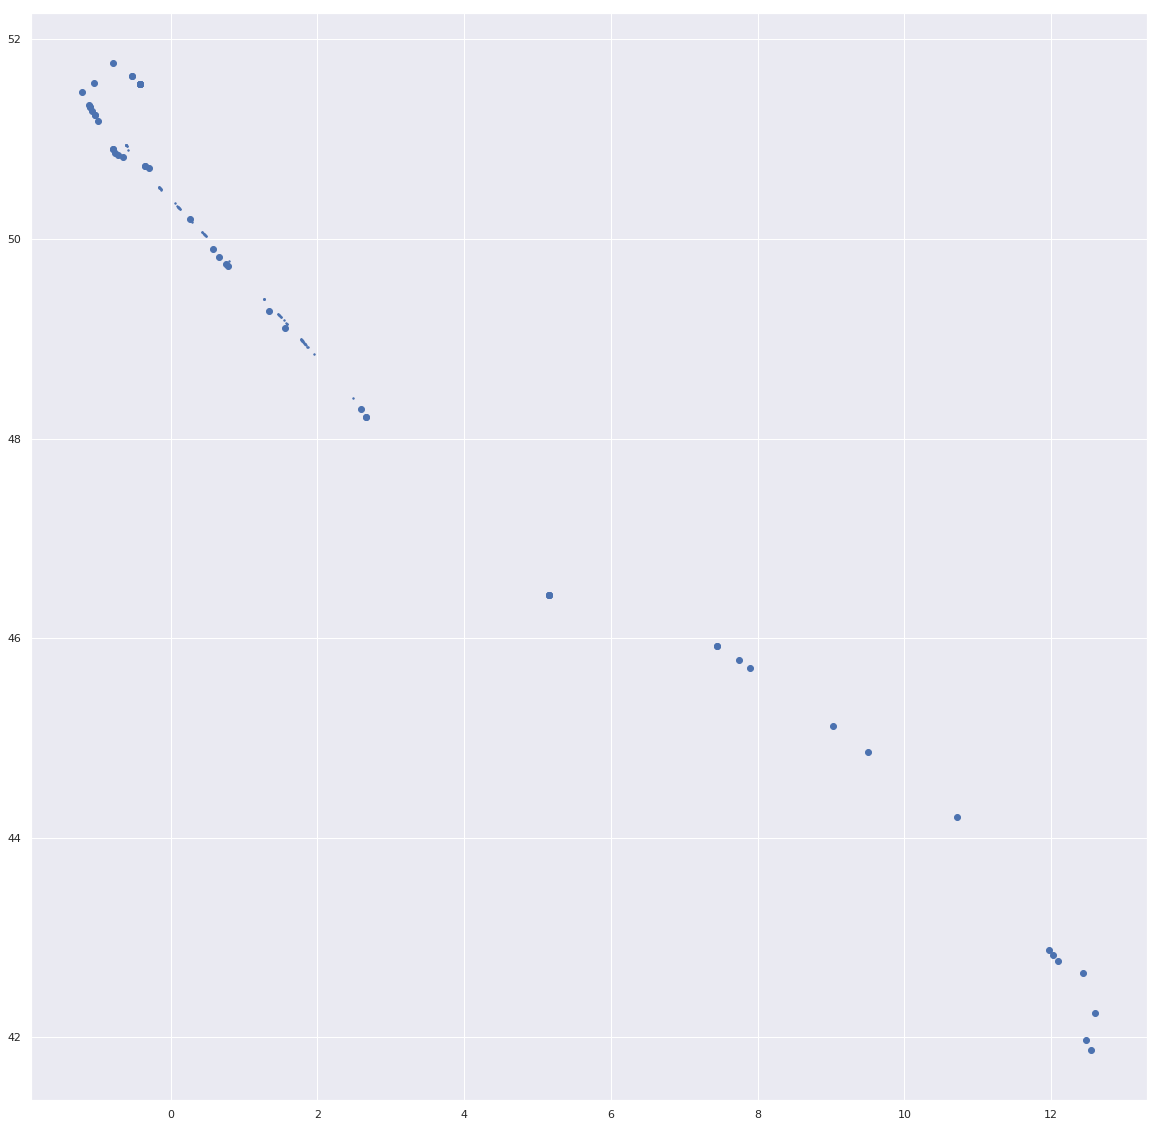

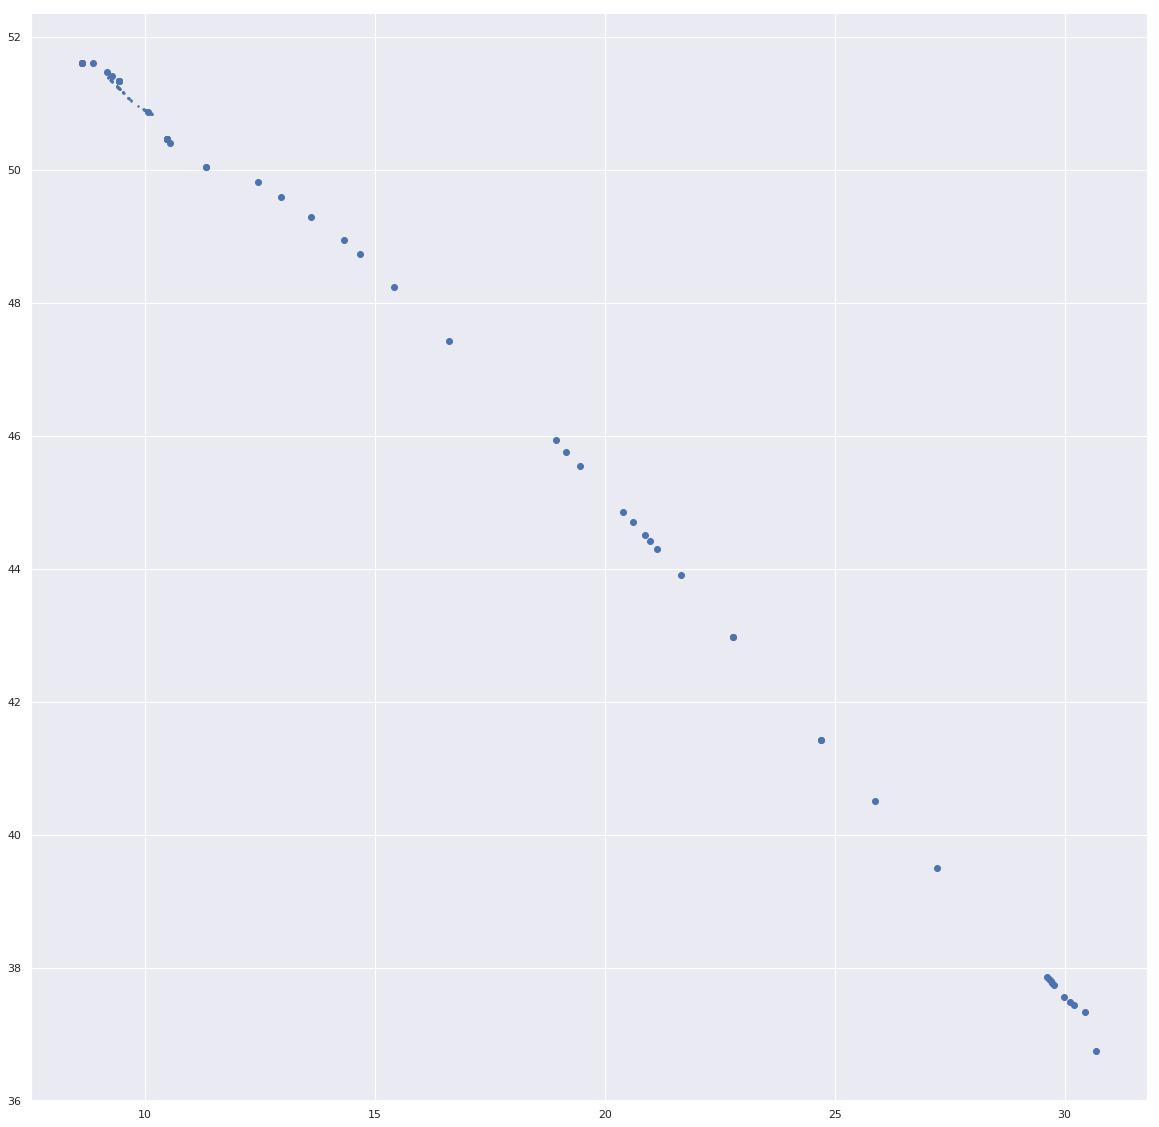

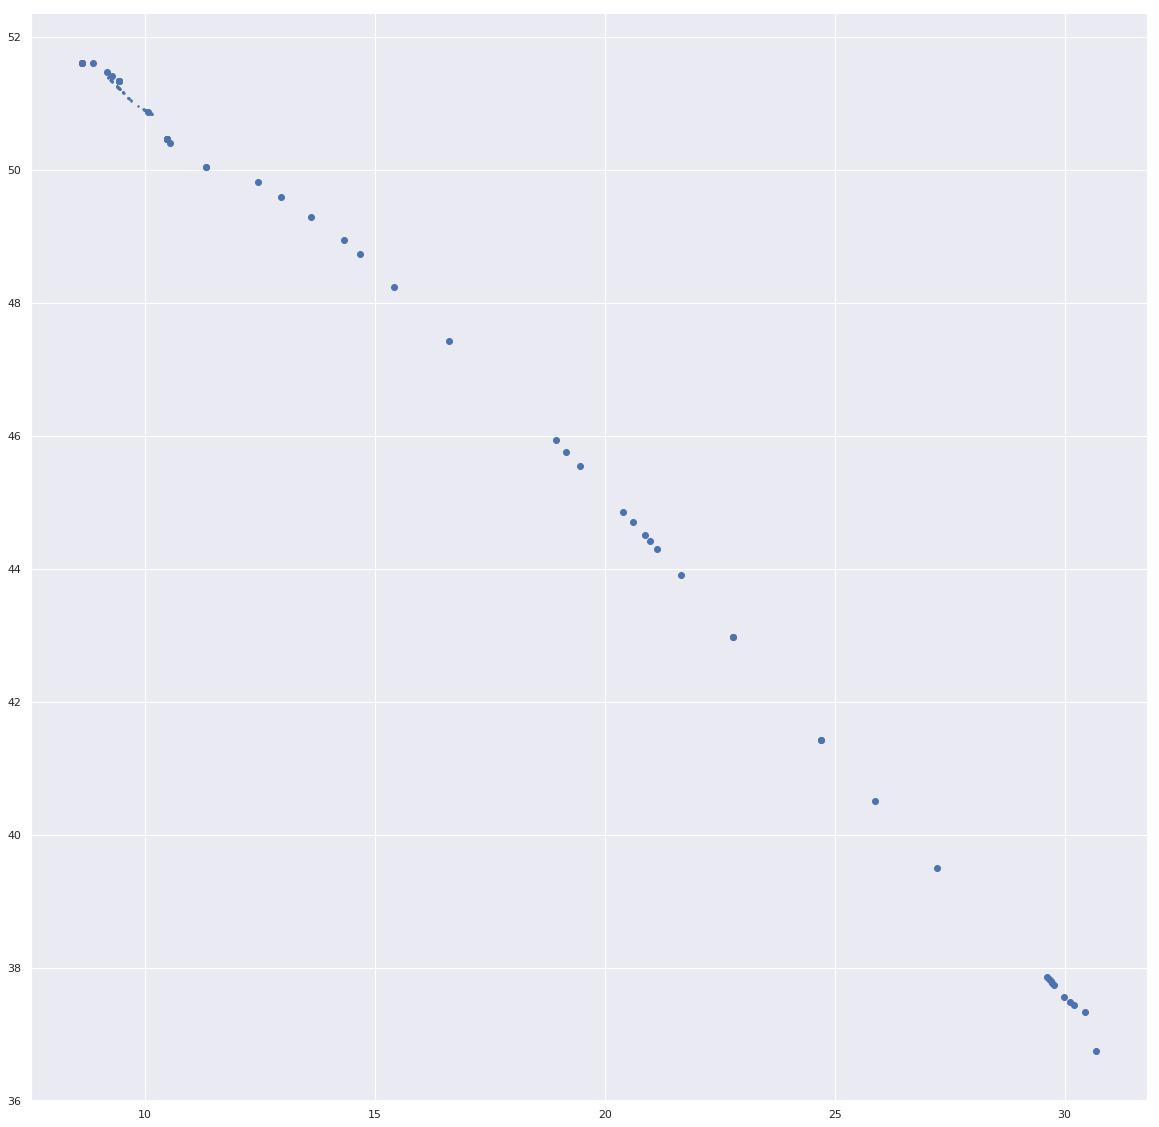

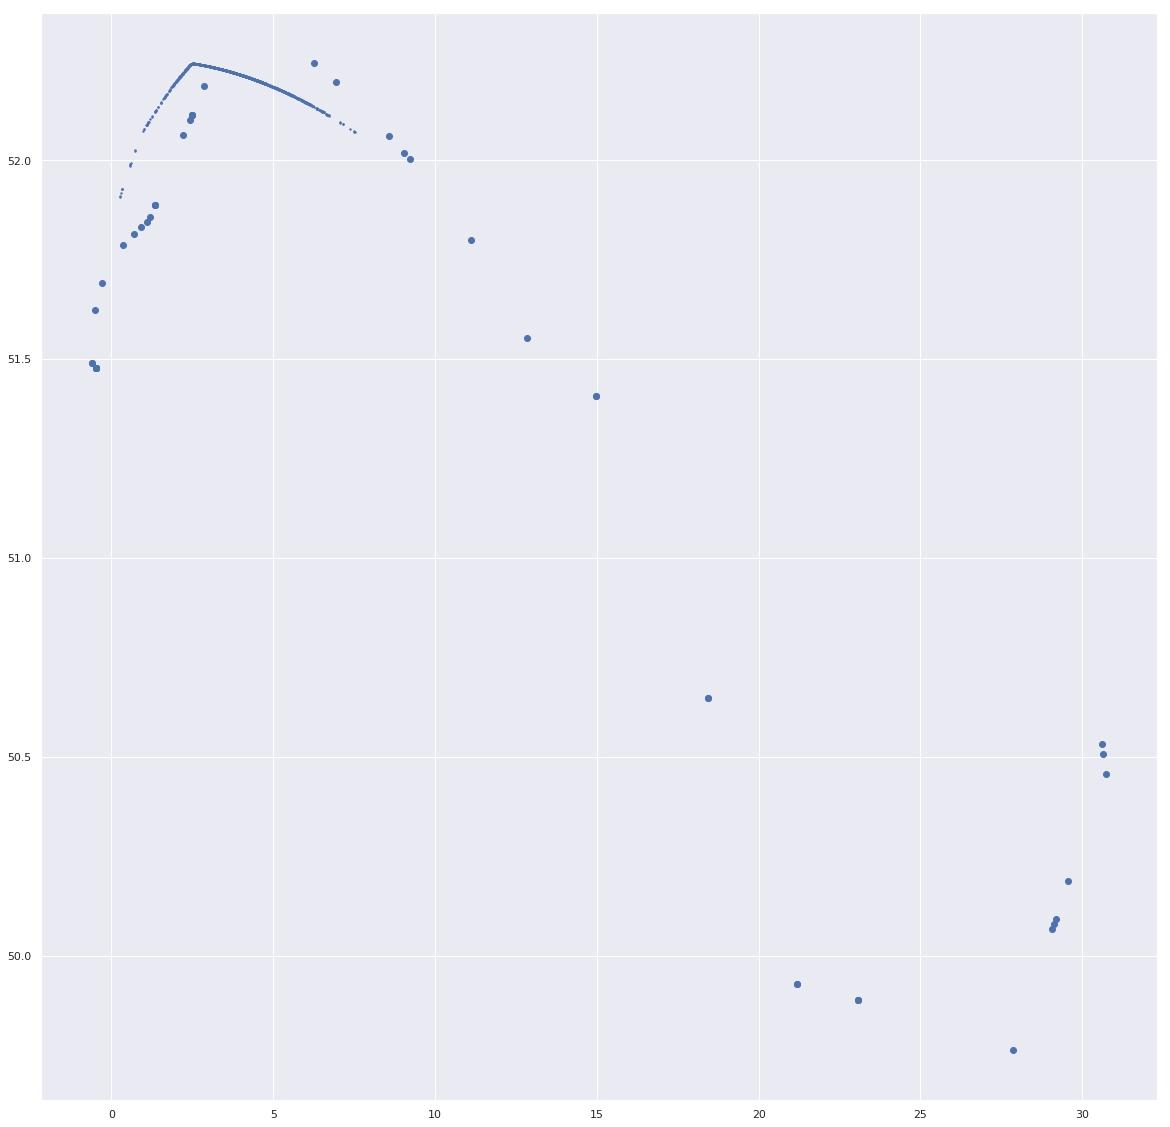

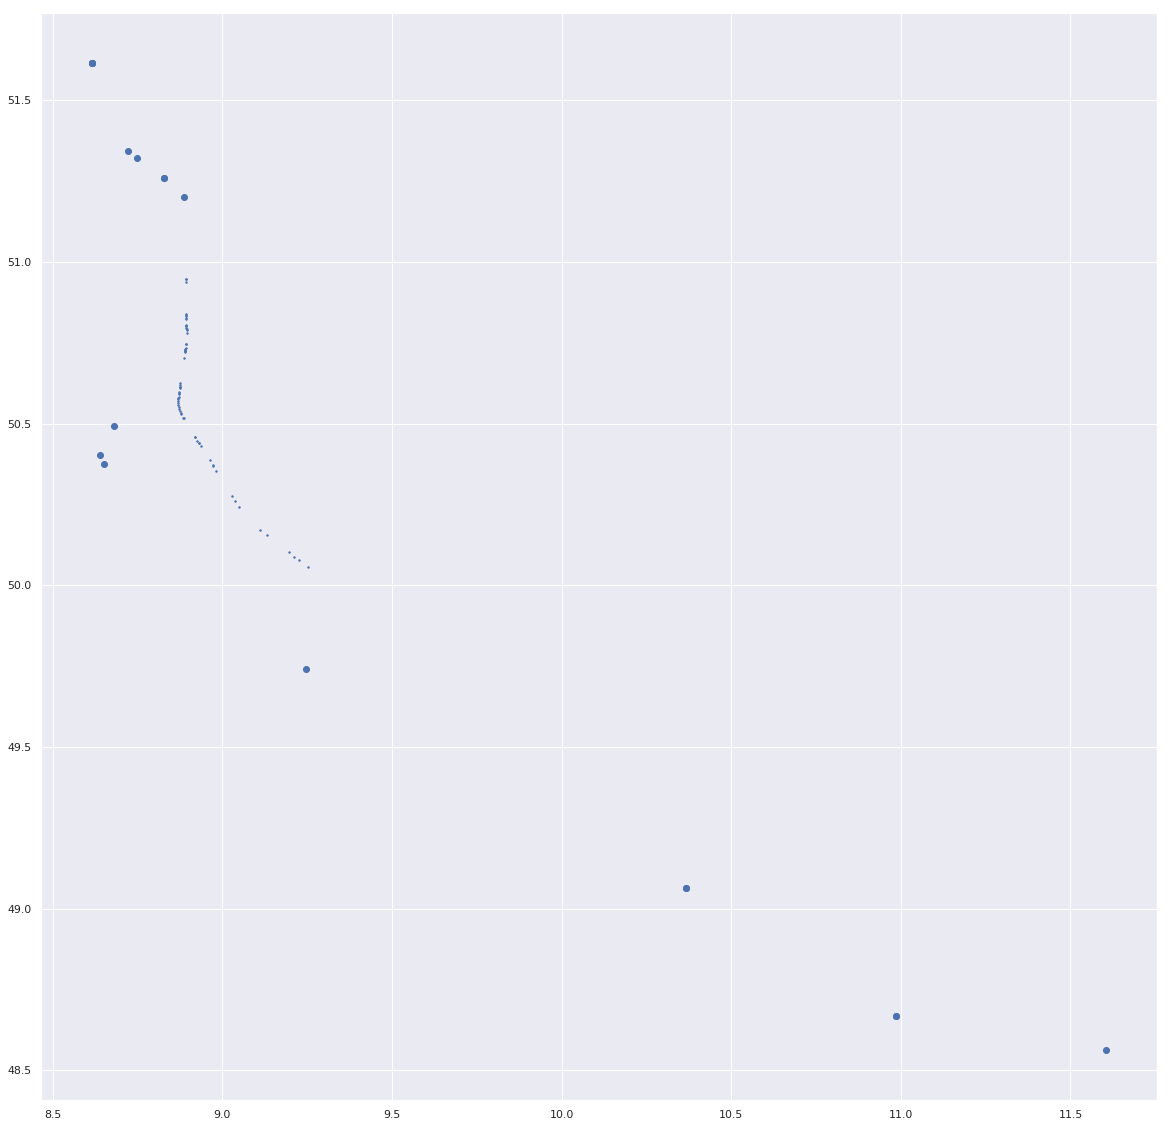

In [24]:
cur_read.execute("select * from public.adsb_ddr2m3_flights limit 10;")


# lat_bounds = [49, 56]
# lon_bounds = [1, 8]

for dm1 in cur_read.fetchall():
    
    try:
#         print(dm1['callsign'])
        plt.figure(figsize=(20,20))
#         print(dm1)
#         a = pd.DataFrame(x['adsb'])
#         dm1 = pd.DataFrame(x['ddr2_m1'])
#         dm3 = pd.DataFrame(x['ddr2_m3'])
        plt.scatter(list(dm1['lon']),list(dm1['lat']), c="b", s=2)
        plt.scatter(list(dm1['lon_seg_b']),list(dm1['lat_seg_b']))
#         plt.scatter(list(dm3['lon_seg_b']),list(dm3['lat_seg_b']), c="g", s=3)
#         plt.scatter(list(a['lon']),list(a['lat']), c="b", s=3)

    except:
        print('failed')

# plt.xlim(tuple(lon_bounds))
# plt.ylim(tuple(lat_bounds))
plt.show()
cur_read.close()
conn.close()

In [ ]:
plt.figure(figsize=(30,30))
lat_bounds = [51, 53.5]
lon_bounds = [2, 6]

for x in col_combi.find({})[:30]:
    try:
        a = pd.DataFrame(x['adsb'])
        dm1 = pd.DataFrame(x['ddr2_m1'])
        dm3 = pd.DataFrame(x['ddr2_m3'])
        plt.scatter(list(dm1['lon_seg_b']),list(dm1['lat_seg_b']), c="r", s=3)
        plt.scatter(list(dm3['lon_seg_b']),list(dm3['lat_seg_b']), c="g", s=3)
        plt.scatter(list(a['lon']),list(a['lat']), c="b", s=3)
        plt.xlim(tuple(lon_bounds))
        plt.ylim(tuple(lat_bounds))
    except:
        continue

    
plt.show()

<h2>Visualization of CTE over look ahead time for planned route</h2>
The calculated CTE between the DDR2-m1 data and ADS-B data is plotted against the look-ahead time. 

In [3]:
import matplotlib.pyplot as plt

try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

max_inserts = 100
fetch_batch_size = max_inserts
cnt = 0

cur_read = conn.cursor(cursor_factory=RealDictCursor)

cur_read.execute("select * from public.adsb_ddr2m3_flights limit 5000;")

proj_dct = {}
plt.figure(figsize=(30,10))
bin_cte = []
bin_dp_df = {}
la_time = 1200
bin_sec = 20

for x in cur_read.fetchall():
    
    dc = {k: x[k] for k in ['ep_seg_b','lat_seg_b', 'lon_seg_b']}
    ac = {k: x[k] for k in ['ts','lat','lon']}
    
    dc = pd.DataFrame.from_dict(dc)
    ac = pd.DataFrame.from_dict(ac)

    dc['wps'] = list(zip(dc.lat_seg_b, dc.lon_seg_b))
    try:
        df = add_waypoints_free(ac, dc['wps'])
    except Exception as e:
        print(e)
        continue

    df[['curr_lat', 'curr_lon']] = df['curr_wp'].apply(pd.Series)
    df[['next_lat', 'next_lon']] = df['next_wp'].apply(pd.Series)
    df[['last_lat', 'last_lon']] = df['last_wp'].apply(pd.Series)
    
    cte_arr = []
    ate_arr = []
    tte_arr = []

    fl_dd = pd.DataFrame()

    for ii, r in df.iterrows():
#         print(r)
        cte, ate, tte = calc_track_errors(r['last_wp'], r['curr_wp'], r['wp_ac'])
        cte_arr.append(cte)
        ate_arr.append(ate)
        tte_arr.append(tte)


    fl_dd['cte'] = cte_arr
    fl_dd['ate'] = ate_arr
    fl_dd['tte'] = tte_arr
    fl_dd['time_proj'] = df['ts'] - df['ts'].min()
    
    for b in range(int(la_time/bin_sec)):
        bmin = b*bin_sec
        bmax = (b+1)*bin_sec
        if str(bmax)+'_cte' not in list(bin_dp_df.keys()):
            bin_dp_df[str(bmax)+'_cte'] = []
            
        bin_dp_df[str(bmax)+'_cte'].extend(fl_dd['cte'][(fl_dd['time_proj'] >= bmin) & (fl_dd['time_proj'] <= bmax)])
    
    bin_cte.extend(cte_arr)
    
#     plt.figure(figsize=(30,30))
#     plt.scatter(df['curr_lat'],df['curr_lon'], c='g')
#     plt.scatter(df['lat'], df['lon'],c='b')
#     plt.scatter(fl_dd['time_proj'],fl_dd['cte'],s=2, c='b')
# plt.ylim((-100000,100000))
# plt.xlim((0,1200))    
# plt.show()


Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalou

Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalou

Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalou

Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalou

Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalou

Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalou

math domain error
math domain error
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anom

Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalou

Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalou

Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalou

Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalou

Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalou

Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalous value
Anomalou

ValueError: Columns must be same length as key

<Figure size 2160x720 with 0 Axes>

The following boxplot shows the distribution of the CTE between the m1 data and ADS-B data in bins of 20 seconds for a look-ahead time up to 3000 seconds from the start of the flight. 

In [4]:
# create bin dataframe
box_data = []
bin_df = bin_dp_df

for k in bin_df.keys():
    if '_cte' in k:
        box_data.append((int(k.strip('_cte')), [i for i in bin_df[k] if not np.isnan(i)]))
    
box_data_sort = sorted(box_data, key=lambda tup: tup[0])
box_data_2 = [i[1] for i in box_data_sort]

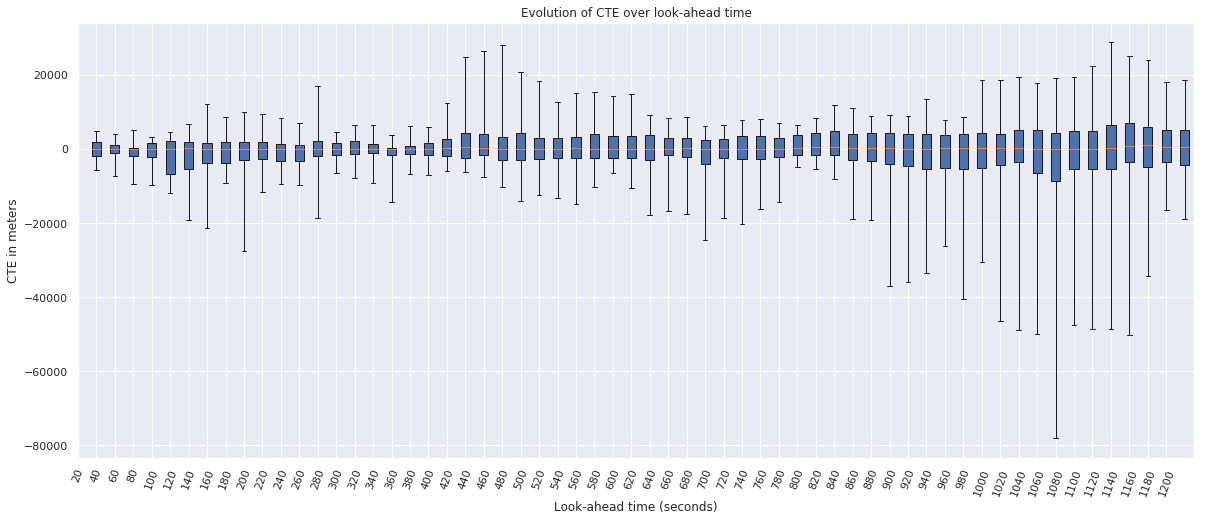

In [10]:
x = range(len(box_data_2))
plt.figure(figsize=(20,8))
plt.boxplot(box_data_2, showfliers=False, patch_artist=True, whis=[10,90])
# plt.hlines(9260, 0, 1200, colors='r', linestyles='dashed', label='IPZ limit')
# plt.hlines(-9260, 0, 1200, colors='r', linestyles='dashed')
# plt.hlines(-9260, 0, 1200, colors='r', linestyles='dashed', label='IPZ limit')
plt.xticks(x, [i[0] for i in box_data_sort])
plt.xticks(rotation=70)
plt.xlabel('Look-ahead time (seconds)')
plt.ylabel('CTE in meters')
plt.title('Evolution of CTE over look-ahead time')
# plt.legend(prop={'size': 16})
# plt.ylim((-100000,100000))
plt.show()

No handles with labels found to put in legend.


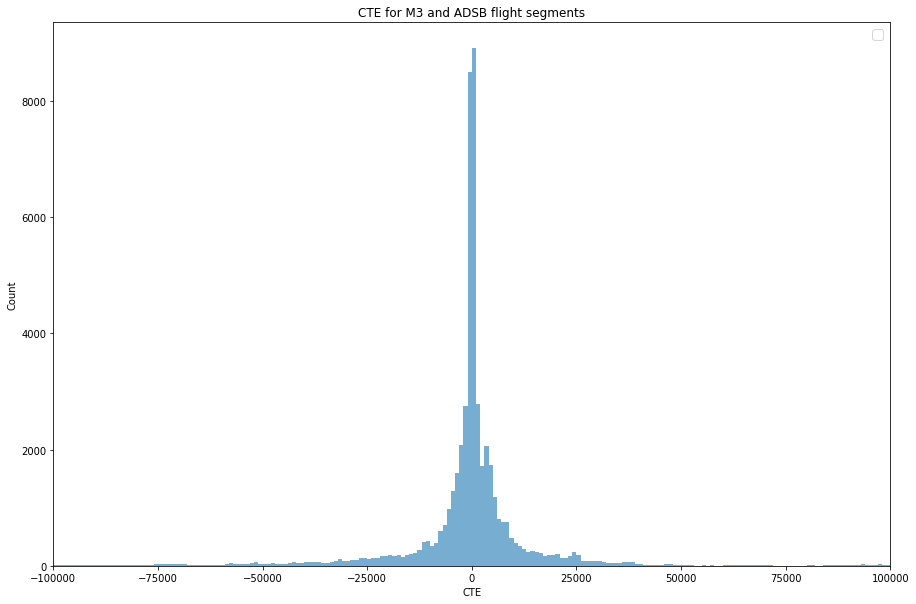

In [9]:
# create bin dataframe
box_data = []
bin_df = bin_dp_df

for k in bin_df.keys():
    if '_cte' in k:
        box_data.extend([i for i in bin_df[k] if not np.isnan(i)])

from matplotlib import mlab
fig, ax = plt.subplots(figsize=(15, 10))
range_lim = 100000

box_data = [x for x in box_data if abs(x) < range_lim]

n_bins = 200

# plot the cumulative histogram
n, bins, patches = ax.hist(box_data, n_bins, normed=0, histtype='stepfilled',
                           cumulative=False, alpha=0.6)
    
#     plt.xlabel('')
# plt.legend(prop={'size': 14})
plt.xlim(-range_lim,range_lim)
# plt.ylim(0,100000)
plt.xlabel('CTE')
plt.ylabel('Count')
plt.title('CTE for M3 and ADSB flight segments')
plt.show()

In [11]:
from scipy import stats

stats.describe(box_data)

DescribeResult(nobs=51419, minmax=(-99966.96675904862, 99964.56601435547), mean=-759.7829257100001, variance=285410255.62557226, skewness=-0.618377349954631, kurtosis=12.049504589513662)

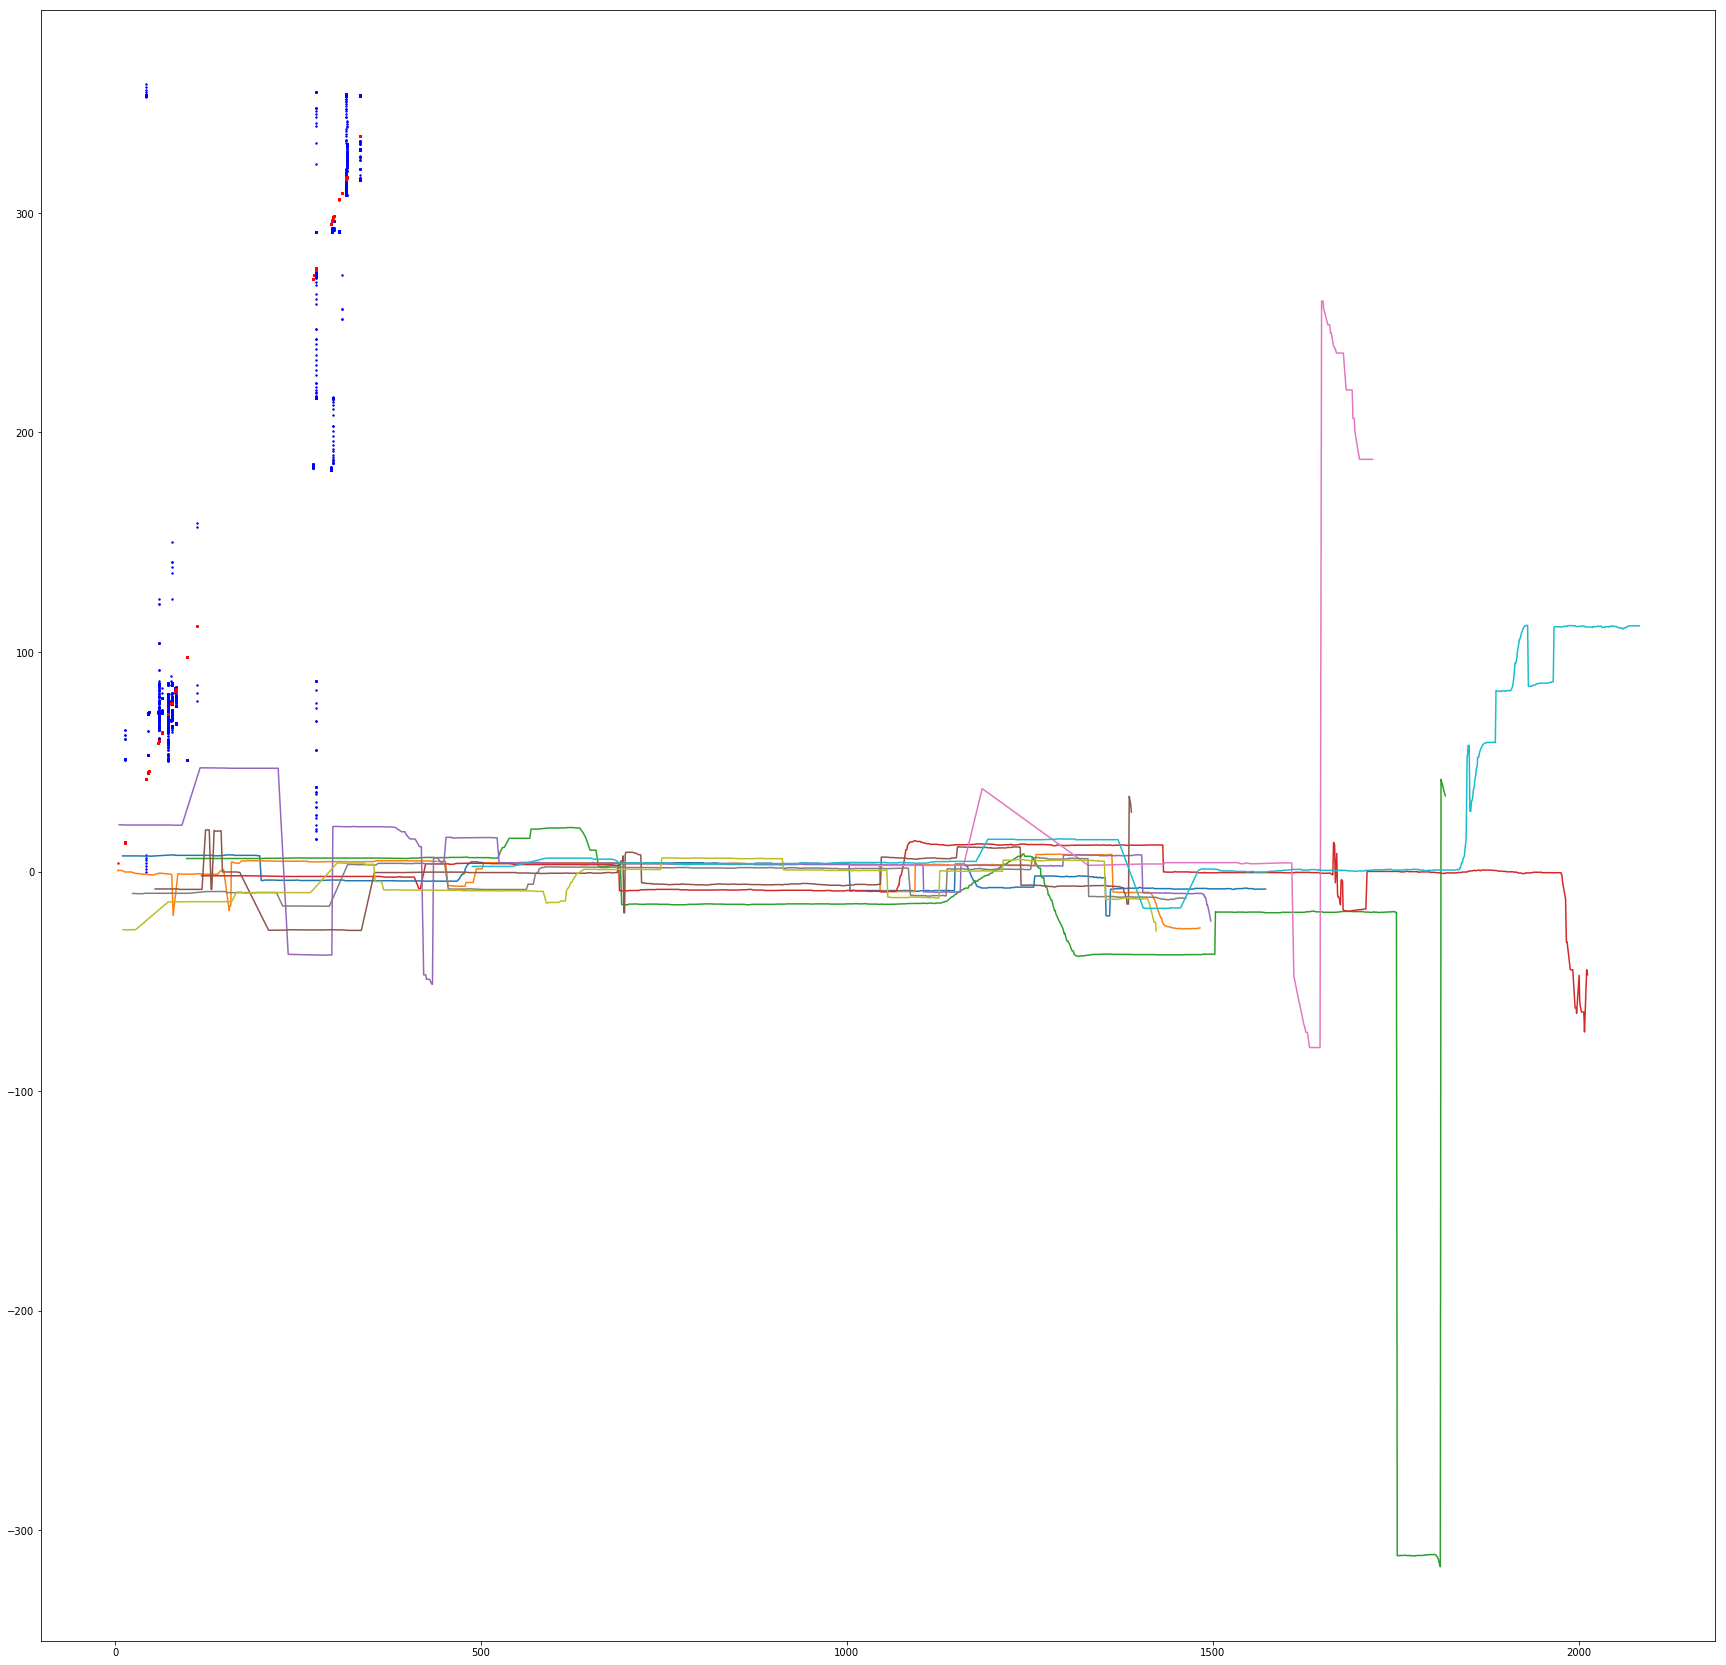

In [9]:
try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

max_inserts = 100
fetch_batch_size = max_inserts
cnt = 0

cur_read = conn.cursor(cursor_factory=RealDictCursor)

cur_read.execute("select t1.callsign, t1.ep_seg_b, t1.lat_seg_b, t1.lon_seg_b, t2.ts, t2.lat, t2.lon, t2.hdg \
                from public.ddr2_flights as t1 inner join public.adsb_flights as t2 \
                on t1.callsign = t2.callsign and abs(t1.start_ep - t2.start_ep) < 6000 limit 10;")


proj_dct = {}
plt.figure(figsize=(30,30))
bin_cte_hdg = []

for x in cur_read.fetchall():
    dc = {k: x[k] for k in ['ep_seg_b','lat_seg_b', 'lon_seg_b']}
    ac = {k: x[k] for k in ['ts','lat','lon', 'hdg']}
    
    dc = pd.DataFrame.from_dict(dc)
    ac = pd.DataFrame.from_dict(ac)

    dc['wps'] = list(zip(dc.lat_seg_b, dc.lon_seg_b))
    try:
        df = add_waypoints_free(ac, dc['wps'])
    except Exception as e:
        print(e)
        continue

    df[['curr_lat', 'curr_lon']] = df['curr_wp'].apply(pd.Series)
    df[['next_lat', 'next_lon']] = df['next_wp'].apply(pd.Series)
    df[['last_lat', 'last_lon']] = df['last_wp'].apply(pd.Series)
    
    hdg_ac_arr = []
    hdg_route_arr = []
    hdg_diff_arr = []

    fl_dd = pd.DataFrame()

    for ii, r in df.iterrows():

        route_hdg = calc_compass_bearing(r['last_wp'], r['curr_wp'])
        hdg_ac_arr.append(r['hdg'])
        hdg_route_arr.append(route_hdg)
        hdg_diff_arr.append(route_hdg - r['hdg'])

    fl_dd['hdg_ac'] = hdg_ac_arr
    fl_dd['hdg_ac'] = fl_dd['hdg_ac'].fillna(method='ffill')
    fl_dd['hdg_route'] = hdg_route_arr
    fl_dd['time_proj'] = df['ts'] - df['ts'].min()
    
    plt.scatter(fl_dd['hdg_route'],fl_dd['hdg_ac'],s=2, c='b')
    plt.scatter(fl_dd['hdg_route'],fl_dd['hdg_route'],s=2, c='r')
    plt.plot(fl_dd['time_proj'], fl_dd['hdg_route']-fl_dd['hdg_ac'])
    
    bin_cte_hdg.extend(hdg_diff_arr)
    
plt.show()
    
#     plt.figure(figsize=(30,30))
#     plt.scatter(df['curr_lon'],df['curr_lat'],s=2, c='b')
#     plt.scatter(df['lon'],df['lat'],s=2, c='r')
#     plt.show()
    
#     plt.figure(figsize=(30,30))
#     plt.plot(fl_dd['hdg_route'],'-b')
#     plt.plot(fl_dd['hdg_ac'], '-r')
#     plt.show()
#     bin_cte.extend(cte_arr)

In [ ]:
bin_cte = pd.Series(bin_cte)
bin_cte.plot.hist(bins=500,figsize=(20,10),xlim=(-60000,60000),alpha = 0.6)

In [ ]:
bin_cte_hdg = pd.Series(bin_cte_hdg)
bin_cte_hdg.plot.hist(bins=100,figsize=(20,10),alpha=0.7)

In [ ]:
plt.figure(figsize=(20,20))
for i, r in df.iterrows(): 
    plt.plot([r['curr_lat'],r['lat']],[r['curr_lon'],r['lon']], 'r--')
    plt.plot([r['next_lat'],r['lat']],[r['next_lon'],r['lon']], 'k--')

for i, r in df.iterrows(): 
    plt.scatter(r['lat'],r['lon'],c='b',marker='x')
    plt.scatter(r['curr_lat'],r['curr_lon'],c='g',marker='x')
    
plt.show()